## Expression evaluation in memory

In this bench we will evaluate some expressions in memory for ironArray, NumPy, Zarr, numba, and HDF5. To do that, we will use the same data that in the [Expression evaluation in memory](../tutorials/06.Expression_Evaluation_(In-Memory).html) tutorial:

In [1]:
%load_ext memprofiler
%matplotlib inline
import iarray as ia
import numpy as np
import zarr
import dask.array as da
import h5py
import hdf5plugin as h5plugin
import os
from numcodecs import blosc, Blosc

In [2]:
%%mprof_run -i 0.1 load
chunks = (360, 128, 1440)
ia.set_config_defaults(chunks=chunks, blocks=(8, 8, 720))
precip1 = ia.load("../tutorials/precip1.iarr", chunks=chunks, blocks=(8, 8, 720))
precip2 = ia.load("../tutorials/precip2.iarr", chunks=chunks, blocks=(8, 8, 720))
precip3 = ia.load("../tutorials/precip3.iarr", chunks=chunks, blocks=(8, 8, 720))
print(precip1.info)

type   : IArray
shape  : (720, 721, 1440)
chunks : (360, 128, 1440)
blocks : (8, 8, 720)
cratio : 8.70

memprofiler: used 1096.46 MiB RAM (peak of 1589.64 MiB) in 9.2203 s, total RAM usage 1325.12 MiB


### ironArray

#### Mean evaluation

In [3]:
shape = precip1.shape

In [4]:
precip_mean_expr = ia.expr_from_string("(p1 + p2 + p3) / 3", {'p1': precip1, 'p2': precip2, 'p3': precip3})

In [5]:
%%mprof_run iarray::mean
precip_mean = precip_mean_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

memprofiler: used 936.51 MiB RAM (peak of 936.51 MiB) in 0.3703 s, total RAM usage 2278.12 MiB


In [6]:
%%mprof_run iarray::mean_lazy
precip_mean_expr_lazy = (precip1 + precip2 + precip3) / 3
precip_mean_lazy = precip_mean_expr_lazy.eval()
precip_mean_lazy

<IArray (720, 721, 1440) np.float32>

memprofiler: used 952.18 MiB RAM (peak of 952.18 MiB) in 0.3755 s, total RAM usage 3230.35 MiB


#### Expressions with transcendental functions

In [7]:
%%mprof_run iarray::trans
precip_trans = ia.expr_from_string("(tan(p1) * (sin(p1) * sin(p2) + cos(p2)) + sqrt(p3) * 2)",
                             {'p1': precip1, 'p2': precip2, 'p3': precip3}
                             ).eval()
precip_trans

<IArray (720, 721, 1440) np.float32>

memprofiler: used 871.20 MiB RAM (peak of 871.20 MiB) in 0.5490 s, total RAM usage 4101.57 MiB


In [8]:
%%mprof_run iarray::trans_lazy
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2

precip_trans_lazy = lazy_expr.eval()
precip_trans_lazy

<IArray (720, 721, 1440) np.float32>

memprofiler: used 871.18 MiB RAM (peak of 871.18 MiB) in 0.5603 s, total RAM usage 4972.75 MiB


### NumPy

#### Mean evaluation

In [9]:
%%mprof_run
np_precip1 = precip1.data
np_precip2 = precip2.data
np_precip3 = precip3.data

memprofiler: used 8559.40 MiB RAM (peak of 8785.55 MiB) in 3.0288 s, total RAM usage 13532.16 MiB


In [10]:
%%mprof_run numpy::mean
np_mean = (np_precip1 + np_precip2 + np_precip3) / 3

memprofiler: used 2852.17 MiB RAM (peak of 2852.17 MiB) in 2.0363 s, total RAM usage 16384.40 MiB


#### Expressions with transcendental functions

In [11]:
%%mprof_run numpy::trans
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_trans = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

memprofiler: used 2214.79 MiB RAM (peak of 7779.88 MiB) in 16.8543 s, total RAM usage 18599.21 MiB


In [12]:
del np_mean
del p1_
del p2_
del p3_
del np_trans

### Numba

Numba is a well known library for performing efficient computations with NumPy arrays:

#### Mean evaluation

In [13]:
import numba as nb
@nb.jit(nopython=True, parallel=True)
def mean_numba(x, y, z):
    out = np.empty(x.shape, x.dtype)
    for i in nb.prange(len(x)):
        out[i] = (x[i] + y[i] + z[i]) / 3
    return out

In this example we are enforcing numba to execute outside the Python interpreter (`nopython=True`) for leveraging the parallelism support in numba (`parallel=True`). We will compute the mean twice because the first time numba loses some time initializing buffers.

In [14]:
%%mprof_run
nb_mean = mean_numba(np_precip1, np_precip2, np_precip3)

memprofiler: used 3008.22 MiB RAM (peak of 3008.22 MiB) in 1.4894 s, total RAM usage 15991.09 MiB


In [15]:
# Avoid tracking memory consumption of this object
del nb_mean

In [16]:
%%mprof_run numba::mean
nb_mean = mean_numba(np_precip1, np_precip2, np_precip3)

memprofiler: used 2846.72 MiB RAM (peak of 2846.72 MiB) in 0.8492 s, total RAM usage 15991.34 MiB


#### Expressions with transcendental functions

In [17]:
import numba as nb
@nb.jit(nopython=True, parallel=True)
def trans_numba(x, y, z):
    out = np.empty(x.shape, x.dtype)
    for i in nb.prange(len(x)):
        out[i] = (np.tan(x[i]) * (np.sin(x[i]) * np.sin(y[i]) + np.cos(y[i])) + np.sqrt(z[i]) * 2)
    return out

In this example we are enforcing numba to execute outside the Python interpreter (`nopython=True`) for leveraging the parallelism support in numba (`parallel=True`). We will compute the mean twice because the first time numba loses some time initializing buffers.

In [18]:
%%mprof_run
nb_trans = trans_numba(np_precip1, np_precip2, np_precip3)

memprofiler: used 2848.68 MiB RAM (peak of 2848.68 MiB) in 1.3180 s, total RAM usage 18845.23 MiB


In [19]:
# Avoid tracking memory consumption of this object
del nb_trans

In [20]:
%%mprof_run numba::mean
nb_trans = trans_numba(np_precip1, np_precip2, np_precip3)

memprofiler: used 2846.77 MiB RAM (peak of 2846.77 MiB) in 0.8392 s, total RAM usage 18845.52 MiB


In [21]:
del np_precip1
del np_precip2
del np_precip3

del nb_mean
del nb_trans

### Zarr

#### Mean evaluation

In [22]:
%%time
compressor = Blosc(cname='lz4', clevel=5, shuffle=Blosc.SHUFFLE)
zarr_precip1 = zarr.array(precip1.data, chunks=chunks, compressor=compressor)
zarr_precip2 = zarr.array(precip2.data, chunks=chunks, compressor=compressor)
zarr_precip3 = zarr.array(precip3.data, chunks=chunks, compressor=compressor)

print(zarr_precip1.chunks)

(360, 128, 1440)
CPU times: user 25.1 s, sys: 5.77 s, total: 30.9 s
Wall time: 5.93 s


In [23]:
zdask1 = da.from_zarr(zarr_precip1)
zdask2 = da.from_zarr(zarr_precip2)
zdask3 = da.from_zarr(zarr_precip3)

In [24]:
%%mprof_run zarr::mean
        
zdask_mean = (zdask1 + zdask2 + zdask3) / 3

zarr_mean = zarr.create(shape=precip_mean.shape)
da.to_zarr(zdask_mean, zarr_mean)

memprofiler: used 1365.42 MiB RAM (peak of 11149.43 MiB) in 4.3454 s, total RAM usage 6997.10 MiB


In [25]:
del zarr_mean
del zdask_mean

#### Expressions with transcendental functions

In [26]:
%%mprof_run zarr::trans
zdask_trans = (da.tan(zdask1) * (da.sin(zdask1) * da.sin(zdask2) + da.cos(zdask2)) + da.sqrt(zdask3) * 2)
zarr_trans = zarr.create(shape=zarr_precip1.shape)
da.to_zarr(zdask_trans, zarr_trans)

memprofiler: used -4940.26 MiB RAM (peak of 22997.90 MiB) in 23.7224 s, total RAM usage 2056.59 MiB


In [27]:
del zarr_precip1
del zarr_precip2
del zarr_precip3

del zdask1
del zdask2
del zdask3

del zdask_trans
del zarr_trans

### HDF5

#### Mean evaluation

In [28]:
h5_urlpath1 = "precip1.hdf5"
h5_urlpath2 = "precip2.hdf5"
h5_urlpath3 = "precip3.hdf5"

if not os.path.exists(h5_urlpath1):
    with h5py.File(h5_urlpath1, "w") as f:
        h5_precip1 = f.create_dataset("h5_precip1", precip1.shape, dtype=precip1.dtype, chunks=precip1.chunks, **h5plugin.Blosc())
        precip1.copyto(h5_precip1)
h5_file1 = h5py.File(h5_urlpath1, "r", driver='core', backing_store=False)
precip_h5_1 = h5_file1['h5_precip1']
precip1_h5dask = da.from_array(precip_h5_1)

if not os.path.exists(h5_urlpath2):
    with h5py.File(h5_urlpath2, "w") as f:
        h5_precip2 = f.create_dataset("h5_precip2", precip2.shape, dtype=precip2.dtype, chunks=precip2.chunks, **h5plugin.Blosc())
        precip2.copyto(h5_precip2)
h5_file2 = h5py.File(h5_urlpath2, "r", driver='core', backing_store=False)
precip_h5_2 = h5_file2['h5_precip2']
precip2_h5dask = da.from_array(precip_h5_2)

if not os.path.exists(h5_urlpath3):
    with h5py.File(h5_urlpath3, "w") as f:
        h5_precip3 = f.create_dataset("h5_precip3", precip3.shape, dtype=precip3.dtype, chunks=precip3.chunks, **h5plugin.Blosc())
        precip3.copyto(h5_precip3)
h5_file3 = h5py.File(h5_urlpath3, "r", driver='core', backing_store=False)
precip_h5_3 = h5_file3['h5_precip3']
precip3_h5dask = da.from_array(precip_h5_3)

h5_mean_urlpath = "mean.hdf5"
ia.remove_urlpath(h5_mean_urlpath)

In [29]:
%%mprof_run h5::mean

h5dask_mean = (precip1_h5dask + precip2_h5dask + precip3_h5dask) / 3

f = h5py.File(h5_mean_urlpath, "w", driver='core', backing_store=False)
h5_mean = f.create_dataset(name=h5_mean_urlpath, shape=precip_mean.shape, dtype=precip_mean.dtype, chunks=precip_mean.chunks, **h5plugin.Blosc())
h5dask_mean.to_hdf5(h5_mean_urlpath, 'x')

memprofiler: used 798.04 MiB RAM (peak of 4341.03 MiB) in 34.0288 s, total RAM usage 3729.43 MiB


In [30]:
del h5dask_mean
del h5_mean

#### Expressions with transcendental functions

In [31]:
p1_h5dask = precip1_h5dask
p2_h5dask = precip2_h5dask
p3_h5dask = precip3_h5dask

h5_trans_urlpath = "trans.hdf5"
ia.remove_urlpath(h5_trans_urlpath)

In [32]:
%%mprof_run h5::trans

h5dask_trans = (da.tan(p1_h5dask) * (da.sin(p1_h5dask) * da.sin(p2_h5dask) + da.cos(p2_h5dask)) + da.sqrt(p3_h5dask) * 2)


f = h5py.File(h5_trans_urlpath, "w", driver='core', backing_store=False)
h5_trans = f.create_dataset(name=h5_trans_urlpath, shape=precip_trans.shape, dtype=precip_trans.dtype, chunks=precip_trans.chunks, **h5plugin.Blosc())
h5dask_trans.to_hdf5(h5_trans_urlpath, 'x')

memprofiler: used 488.55 MiB RAM (peak of 6285.56 MiB) in 32.4831 s, total RAM usage 4218.52 MiB


In [33]:
del precip1_h5dask
del precip2_h5dask
del precip3_h5dask
del p1_h5dask
del p2_h5dask
del p3_h5dask

del h5dask_trans
del h5_trans

## Resource consumption

In [34]:
%mprof_plot .*::mean -t "Mean computation"

So, ironArray times are considerably faster than NumPy, Numba, HDF5 and Zarr.  In addition, ironArray also uses much less memory data in compressed form by default.

In this case we see that numba takes less time than NumPy too.  This is because numba is being executed in parallel, and this benefits memory bandwidth in general.  On the other hand, the memory consumption of numba is very close to NumPy (as it should because both are working with uncompressed data).

In [35]:
%mprof_plot .*::trans -t "Transcendental expression"

The picture is quite different for the transcendental expression.  This time ironArray is *way* faster while consuming *much* less memory.  For Numpy this is mainly because it uses large temporaries in this case.

## Memory consumption analysis

Memory efficiency is critical for ironArray, so let's dig a bit more on the pattern of the memory used for both types of computations.

Measuring memory consumption of a Python code in a notebook is challenging because the Python interpreter may decide to free memory at any time, so it is always better to isolate the code that we want to measure in a standalone script and make use of the `mprof` module that comes with the nice `memory_profiler` package.

Let's start with ironArray:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
cfg: Config(codec=<Codec.LZ4: 1>, clevel=9, favor=<Favor.BALANCE: 0>, filters=[<Filter.SHUFFLE: 1>], fp_mantissa_bits=0, use_dict=False, nthreads=32, eval_method=<Eval.AUTO: 1>, seed=2, random_gen=<RandomGen.MERSENNE_TWISTER: 0>, btune=True, dtype=<class 'numpy.float64'>, store=Store(chunks=None, blocks=None, urlpath=None, mode=b'r', contiguous=False), chunks=None, blocks=None, urlpath=None, mode='r', contiguous=None)
load time -> 0.588
cratio: 12.684
mean time -> 0.446
mean time -> 0.722


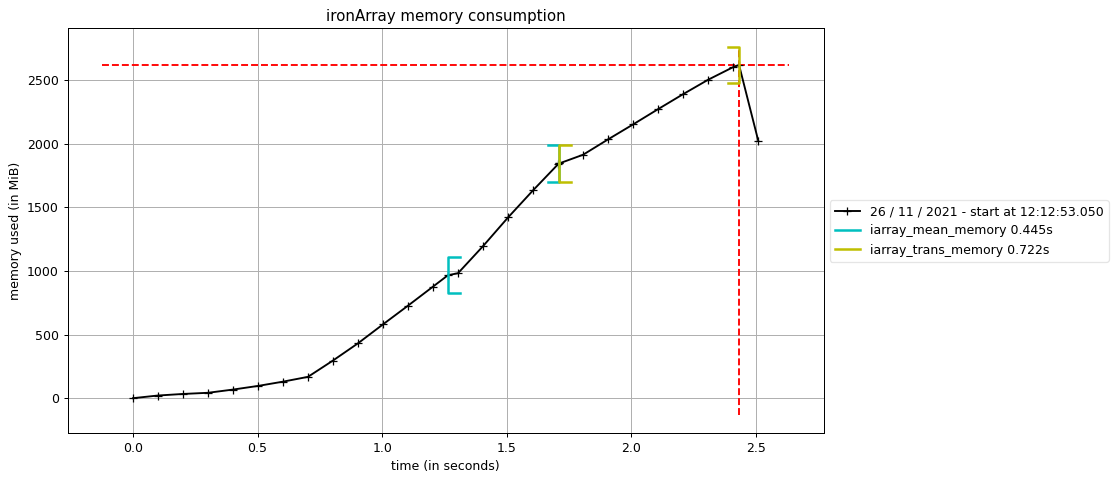

In [36]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

The first part of the plot is the loading process of the 3 months of precipitation arrays from disk.  This process stops when the 1 GB mark is reached, meaning that the (compressed) data takes that storage in memory.  The part between blue brackets corresponds to the actual mean computation and ~1 GB was needed to host the mean array.  Finally, the yellow brackets show the computation of the transcendental expression (around 1 GB more).  In the end, ironArray has needed a grand total of 3 GB so as to evaluate the *two* expresions.

Now, let's see what is the memory consumption for NumPy:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


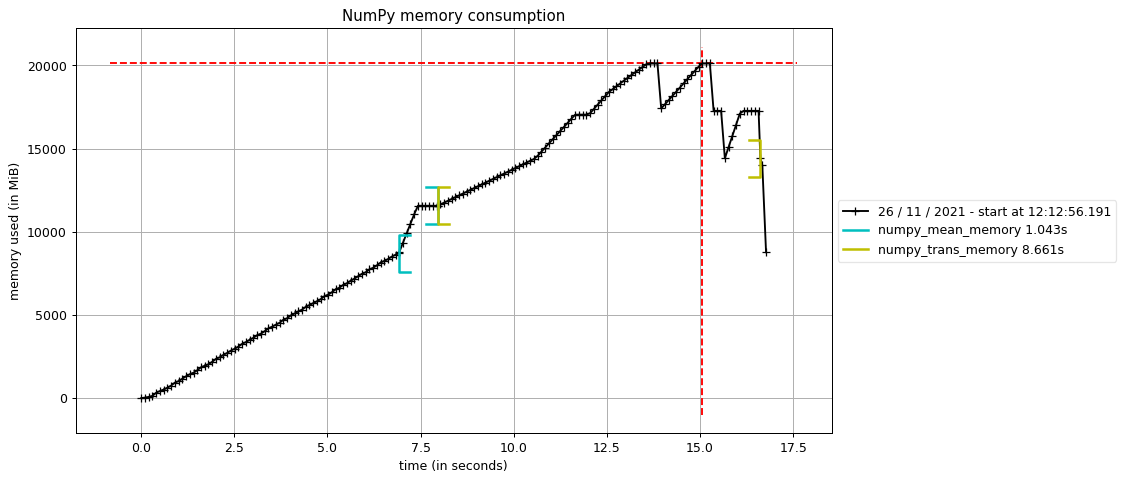

In [37]:
%rm numpy_mean_memory.dat
%run -m mprof run -o numpy_mean_memory.dat numpy_mean_memory.py
%run -m mprof plot numpy_mean_memory.dat -t "NumPy memory consumption"

In this case, the first part of the plot (before the first blue bracket) stops around 8.5 GB (the size of the uncompressed dataset).  The section between blue brackets is where the mean is computed.  In this case, NumPy is well optimized, as it does not seem to use big temporaries (and this is part of the reason on why its computation speed is pretty good).

However, the section for the transcendental evaluation (yellow brackets) shows a more complex pattern, with 2 peaks before reaching the end of the computation.  These peaks clearly correspond to the big temporaries that are needed during the evaluation.  In the end, NumPy has needed around 20 GB so as to evaluate the two expressions.  In comparison, ironArray consumes less than 6x memory for performing the same task.

In general, this means that ironArray can perform operations requiring less memory than using non-compressed arrays, while using a similar time (or much less, like e.g. expressions requiring large temporaries or intermediate function evaluation).

Finally, when we want to minimize the amount of memory during computations, ironArray can also perform evaluations on arrays that are resident on disk (aka out-of-core) in a completely transparent way.  This is the subject of the 'on-disk' counterpart of this tutorial.



